<a href="https://colab.research.google.com/github/HeshanNavindu-7/oilspill-detection/blob/main/oilspill_ResNet_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/saanvitayal07/oil-spill-and-no-oil-spill")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: heshannavindu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/saanvitayal07/oil-spill-and-no-oil-spill


100%|██████████| 26.5M/26.5M [00:01<00:00, 14.9MB/s]


In [4]:
import os
import random
import matplotlib.pyplot as plt
import cv2

#define path
dataset_dir="/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix"
class_count={}
for detection_class in os.listdir(dataset_dir):
  print(detection_class)
  class_dir= os.path.join(dataset_dir,detection_class)
  if os.path.isdir(class_dir):
    num_images=len(os.listdir(class_dir))
    class_count[detection_class]=num_images




test
train


Train Data
Displaying 4 samples from 'nospill' class:
Displaying 4 samples from 'oilspill' class:


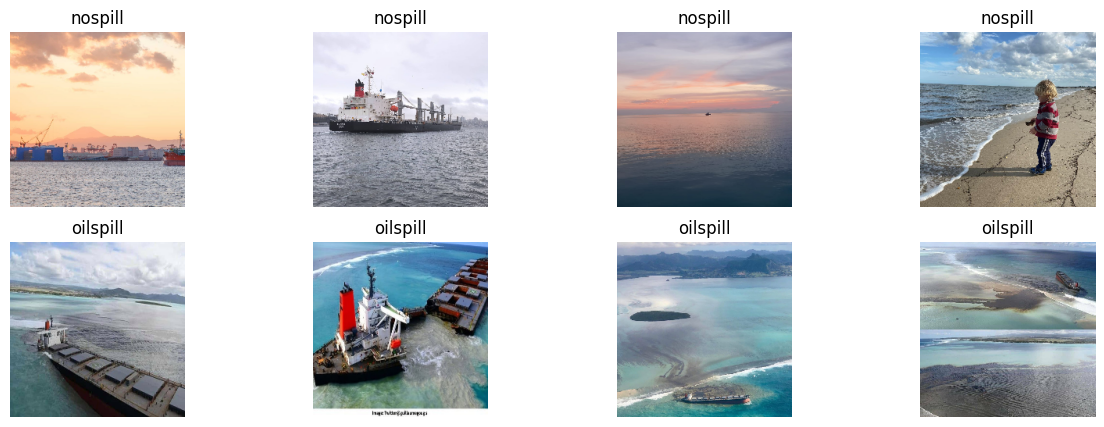

Test Data
Displaying 4 samples from 'nospill' class:
Displaying 4 samples from 'oilspill' class:


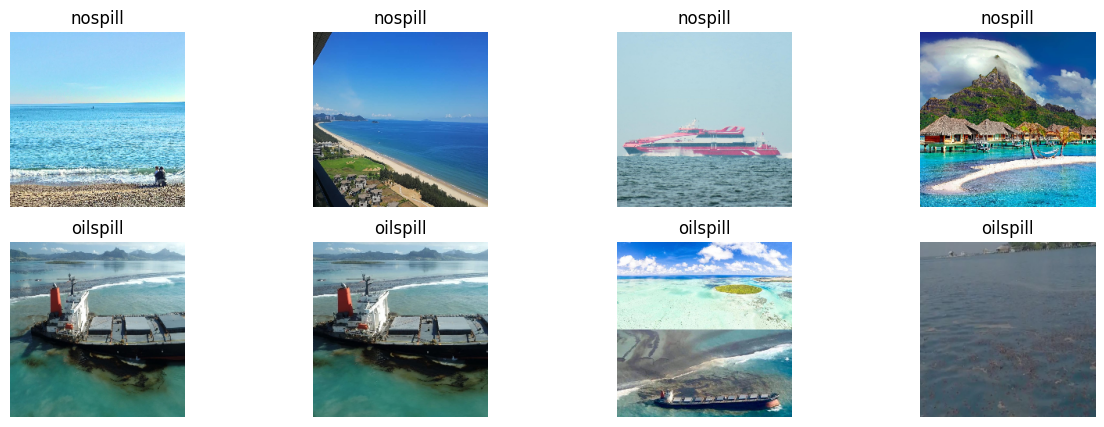

In [5]:
import cv2
import matplotlib.pyplot as plt
import os

# Define subdirectories for train and test data
train_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/train'
test_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/test'

# Define target size for resizing images
target_size = (224, 224)  # Adjust the target size as needed

# Define classes
classes = ['nospill', 'oilspill']

# Display sample data
def display_sample(directory, num_samples=4):
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(15, 5))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)

        if not os.path.exists(class_dir):
            print(f"Directory '{class_dir}' does not exist.")
            continue

        print(f"Displaying {num_samples} samples from '{class_name}' class:")
        files = os.listdir(class_dir)

        if len(files) == 0:
            print(f"No files found in '{class_dir}'.")
            continue

        for j, filename in enumerate(files):
            if j >= num_samples:
                break
            img_path = os.path.join(class_dir, filename)
            if os.path.isfile(img_path):
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                    img = cv2.resize(img, target_size)  # Resize image
                    axs[i, j].imshow(img)
                    axs[i, j].axis('off')
                    axs[i, j].set_title(class_name)
                else:
                    print(f"Failed to read image '{img_path}'.")
            else:
                print(f"'{img_path}' is not a file.")
    plt.show()

print("Train Data")
display_sample(train_dir)
print("Test Data")
display_sample(test_dir)


In [6]:
# Define directories (adjust these paths to your setup)
train_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/train'
test_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/test'

In [ ]:
pip install tensorflow numpy opencv-python imgaug


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import imgaug.augmenters as iaa
import cv2


Found 197 files belonging to 2 classes.


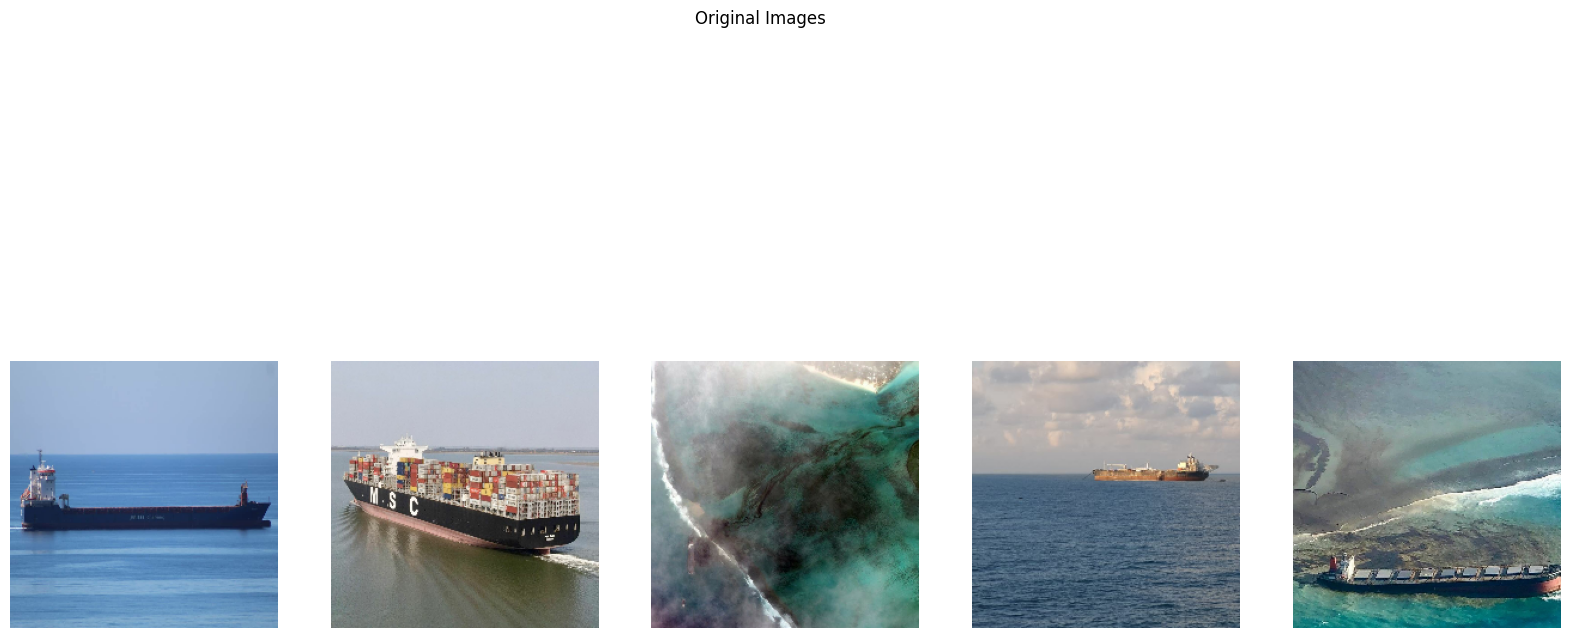

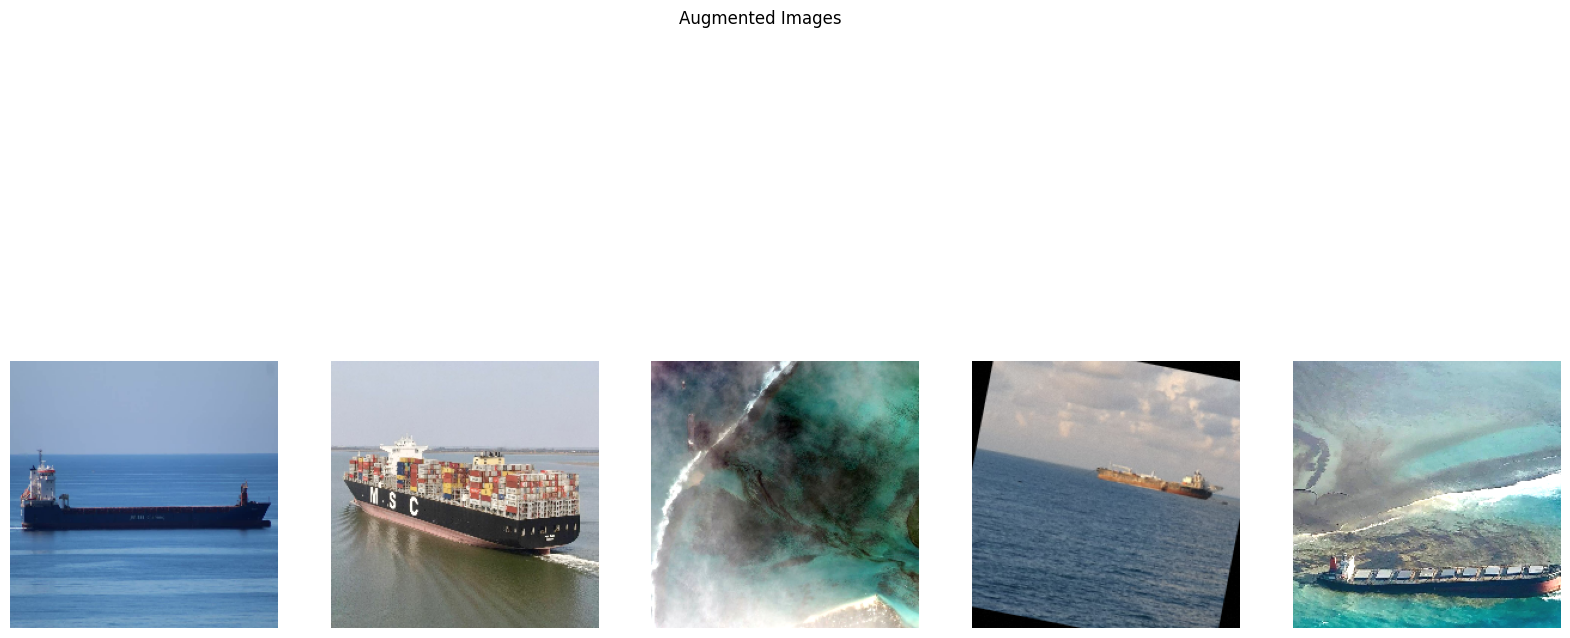

In [8]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

# Workaround for deprecated np.bool
np.bool = bool

# Define augmentation pipelines
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

seq = iaa.Sequential([
    iaa.SomeOf((1, 3), [
        iaa.GaussianBlur(sigma=(0, 1.0)),  # Apply Gaussian blur with a smaller sigma range
        iaa.AdditiveGaussianNoise(scale=(0.0, 0.05*255)),  # Inject Gaussian noise
        iaa.Add((-10, 10), per_channel=0.5),  # Adjust brightness
        iaa.Multiply((0.8, 1.2), per_channel=0.2),  # Adjust brightness and colors
        iaa.Affine(rotate=(-20, 20), scale=(0.8, 1.2)),  # Rotate and scale
        iaa.Fliplr(0.5),  # Horizontal flip
        iaa.Flipud(0.2)  # Vertical flip
    ], random_order=True)
])

def advanced_augmentation(image):
    image = seq.augment_image(image)
    return image

def display_images(images, title='Images'):
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Load and augment images
def load_and_augment_images(directory, batch_size=32, image_size=(224, 224), num_samples=5):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True
    )

    sample_images = []
    sample_labels = []
    for images, labels in dataset.take(1):
        for i in range(min(num_samples, len(images))):  # Ensure we don't exceed the batch size
            sample_images.append(images[i].numpy().astype(np.uint8))
            sample_labels.append(labels[i].numpy())

    augmented_images = []
    for image in sample_images:
        aug_image = advanced_augmentation(image)
        augmented_images.append(aug_image)

    return np.array(sample_images), np.array(augmented_images), np.array(sample_labels)

# Adjust the paths to your setup
train_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/train'
test_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/test'

sample_images, augmented_images, _ = load_and_augment_images(train_dir)

# Display original and augmented images
display_images(sample_images, title='Original Images')
display_images(augmented_images, title='Augmented Images')


Found 197 files belonging to 2 classes.
Found 49 files belonging to 2 classes.


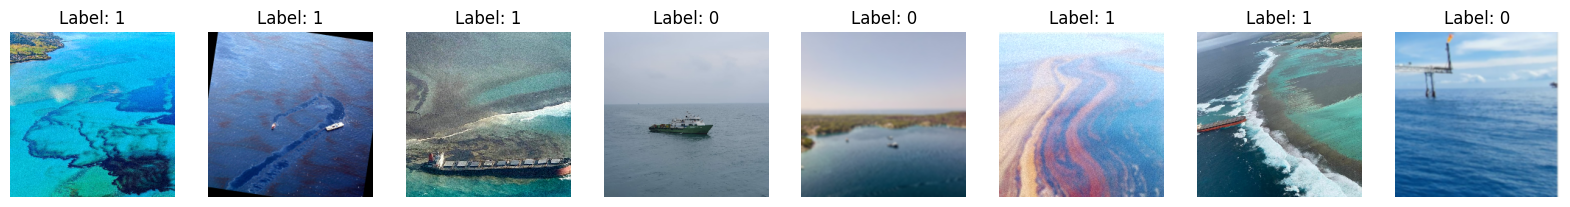

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

# Workaround for deprecated np.bool
np.bool = bool

# Define augmentation pipeline
seq = iaa.Sequential([
    iaa.SomeOf((1, 3), [
        iaa.GaussianBlur(sigma=(0, 3.0)),  # Apply Gaussian blur
        iaa.AdditiveGaussianNoise(scale=(0.0, 0.05*255)),  # Inject Gaussian noise
        iaa.Add((-10, 10), per_channel=0.5),  # Adjust brightness
        iaa.Multiply((0.8, 1.2), per_channel=0.2),  # Adjust brightness and colors
        iaa.Affine(rotate=(-20, 20), scale=(0.8, 1.2)),  # Rotate and scale
        iaa.Fliplr(0.5),  # Horizontal flip
        iaa.Flipud(0.2)  # Vertical flip
    ], random_order=True)
])

def advanced_augmentation(image):
    image = seq.augment_image(image)
    return image

# Load and augment images
def load_and_augment_images(directory, batch_size=32, image_size=(224, 224)):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True
    )
    return dataset

def augment_images(images, labels):
    augmented_images = []
    for image in images:
        aug_image = advanced_augmentation(image.astype(np.uint8))
        augmented_images.append(aug_image)
    augmented_images = np.array(augmented_images)
    return augmented_images, labels

train_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/train'
test_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/test'

train_dataset = load_and_augment_images(train_dir)
test_dataset = load_and_augment_images(test_dir)

# Apply advanced augmentation and ensure the dtype is correct
def process_images(images, labels):
    augmented_images, labels = tf.numpy_function(augment_images, [images, labels], [tf.uint8, tf.int32])
    augmented_images.set_shape([None, 224, 224, 3])  # Ensure shape is set correctly
    labels.set_shape([None])  # Ensure shape is set correctly
    augmented_images = tf.cast(augmented_images, tf.float32) / 255.0  # Rescale pixel values
    return augmented_images, labels

train_dataset = train_dataset.map(process_images, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(process_images, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Example usage: Visualize a batch of augmented images
def display_augmented_images(dataset, num_images=8):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(20, 20))
        for i in range(num_images):
            plt.subplot(1, num_images, i+1)
            plt.imshow(images[i])
            plt.axis('off')
            plt.title(f'Label: {labels[i].numpy()}')
        plt.show()

# Visualize some augmented images from the training dataset
display_augmented_images(train_dataset)


In [13]:
 import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model
def build_model(input_shape=(224, 224, 3), num_classes=2):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

# Compile the model
model = build_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Load and prepare datasets
def load_and_prepare_dataset(directory, batch_size=32, image_size=(224, 224)):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True
    )
    return dataset

train_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/train'
test_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/test'

train_dataset = load_and_prepare_dataset(train_dir)
test_dataset = load_and_prepare_dataset(test_dir)

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


94765736/94765736 [==============================] - 3s 0us/step
Found 197 files belonging to 2 classes.
Found 49 files belonging to 2 classes.
Epoch 1/10
7/7 [==============================] - 70s 9s/step - loss: 1.6032 - accuracy: 0.6447 - val_loss: 0.7100 - val_accuracy: 0.7959 - lr: 0.0010
Epoch 2/10
7/7 [==============================] - 63s 9s/step - loss: 0.1802 - accuracy: 0.9391 - val_loss: 0.4925 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 3/10
7/7 [==============================] - 52s 7s/step - loss: 0.0645 - accuracy: 0.9695 - val_loss: 0.5603 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 4/10
7/7 [==============================] - 52s 7s/step - loss: 0.0174 - accuracy: 0.9949 - val_loss: 0.5461 - val_accuracy: 0.8163 - lr: 0.0010
Epoch 5/10
2/2 [==============================] - 9s 3s/step - loss: 0.4925 - accuracy: 0.8367
Test Loss: 0.4924619197845459
Test Accuracy: 0.8367347121238708


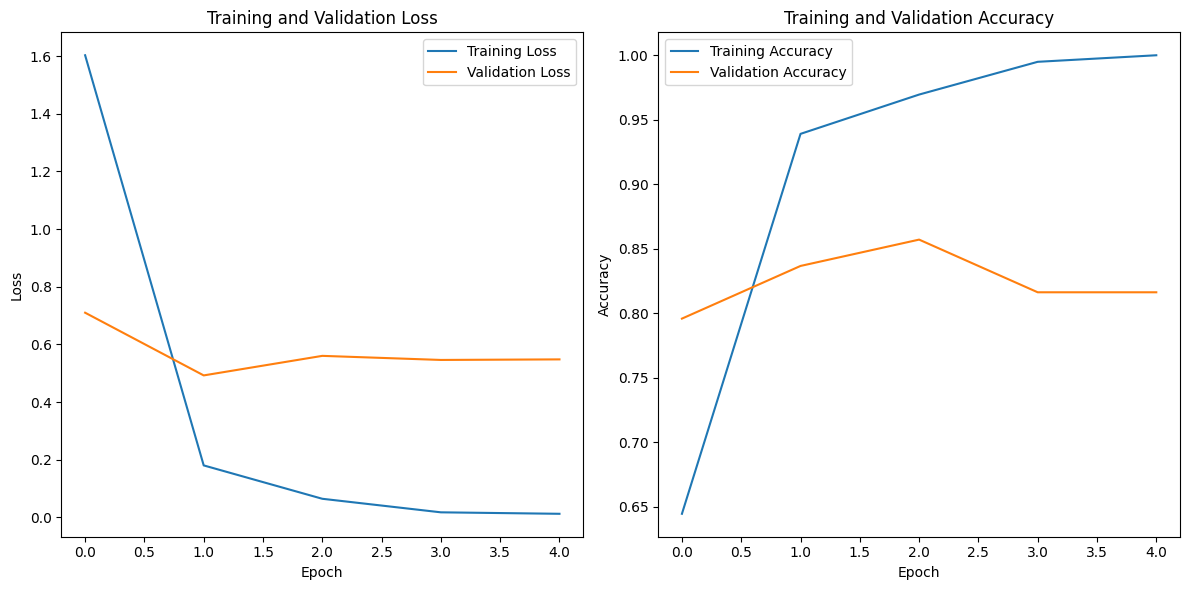

In [14]:
import matplotlib.pyplot as plt

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [16]:
# Assuming you have trained your model and have access to the history object
# The history object contains training and validation metrics for each epoch

# Get the validation accuracy
validation_accuracy = history.history['val_accuracy']

# Print the last validation accuracy recorded during training
print("Validation Accuracy:", validation_accuracy[-1])
# Assuming you have trained your model and have access to the history object
# The history object contains training and validation metrics for each epoch

# Get the validation loss
validation_loss = history.history['val_loss']

# Print the last validation loss recorded during training
print("Validation Loss:", validation_loss[-1])


Validation Accuracy: 0.8163265585899353
Validation Loss: 0.5480504035949707
Validation Accuracy: 0.8163265585899353
Validation Loss: 0.5480504035949707


In [18]:
loss, accuracy = model.evaluate(train_dataset)
print(f'Train Loss: {loss}')
print(f'Train Accuracy: {accuracy}')


7/7 [==============================] - 44s 6s/step - loss: 0.0813 - accuracy: 0.9645
Train Loss: 0.08126770704984665
Train Accuracy: 0.9644669890403748


1/1 [==============================] - 5s 5s/step


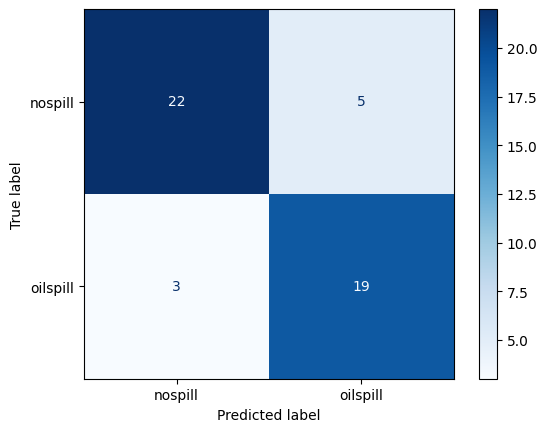

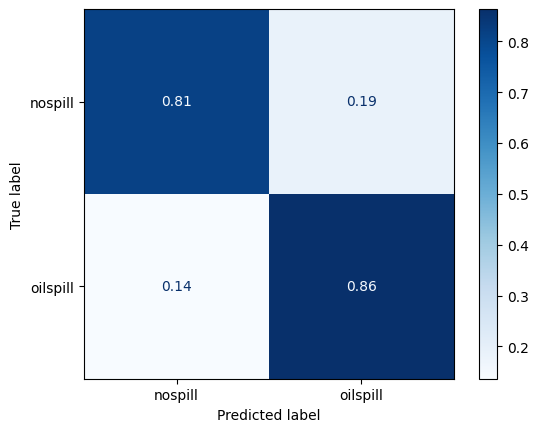

              precision    recall  f1-score   support

     nospill       0.88      0.81      0.85        27
    oilspill       0.79      0.86      0.83        22

    accuracy                           0.84        49
   macro avg       0.84      0.84      0.84        49
weighted avg       0.84      0.84      0.84        49



In [20]:

# Confusion Matrix and Classification Report
def get_true_and_pred_labels(dataset):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    return np.array(y_true), np.array(y_pred)

y_true, y_pred = get_true_and_pred_labels(test_dataset)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_dataset.class_names))

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to load the model
def load_model(model_path):
    try:
        model = tf.keras.models.load_model(model_path)
        print(f"Model loaded successfully from {model_path}")
        return model
    except OSError as e:
        print(f"Error loading model: {e}")
        return None

# Function to preprocess and load an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Function to make a prediction
def predict_image(model, img_path):
    img = load_and_preprocess_image(img_path)
    prediction = model.predict(img)
    return prediction[0], prediction

# Path to the model and the image to be checked
model_path = 'path/to/your/model/oil_spill_detection_xception.h5'
img_path = '/content/sample_data/images.jfif'

# Load the model
model = load_model(model_path)

if model:
    # Make a prediction
    prediction_prob, prediction = predict_image(model, img_path)

    # Print the result and accuracy
    predicted_class = np.argmax(prediction_prob)
    confidence = prediction_prob[predicted_class]

    if predicted_class == 0:
        print(f"The image is predicted to be a no spill image with {confidence:.2f}% confidence.")
    else:
        print(f"The image is predicted to be an oil spill image with {confidence:.2f}% confidence.")

    # Optional: Display the image
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Prediction: {"Oil Spill" if predicted_class == 1 else "No Spill"} (Confidence: {confidence:.2f})')
    plt.axis('off')
    plt.show()
else:
    print("Model could not be loaded. Please check the model path and try again.")


Error loading model: No file or directory found at path/to/your/model/oil_spill_detection_xception.h5
Model could not be loaded. Please check the model path and try again.


1/1 [==============================] - 1s 559ms/step
Image '/content/download (3).jfif' is predicted to be an oil spill image with confidence: 0.95


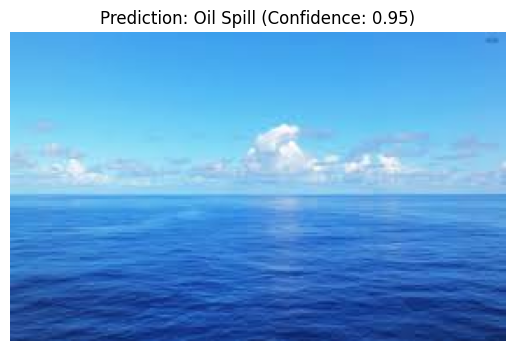

1/1 [==============================] - 0s 384ms/step
Image '/content/images (1).jfif' is predicted to be an oil spill image with confidence: 0.96


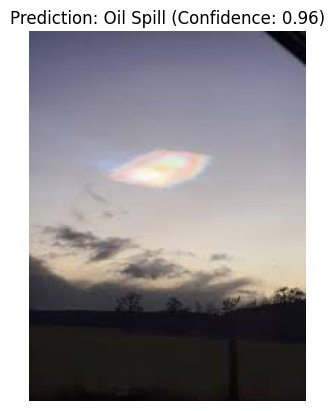

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('oil_spill_detection_xception.h5')

# Function to preprocess and load an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Function to make prediction
def predict_image(model, img_path):
    img = load_and_preprocess_image(img_path)
    prediction = model.predict(img)
    return prediction[0][0], prediction

# Paths to images to be checked
img_paths = ['/content/download (3).jfif', '/content/images (1).jfif']

# Make predictions and print results
for img_path in img_paths:
    prediction_prob, prediction = predict_image(model, img_path)
    if prediction_prob >= 0.5:
        print(f"Image '{img_path}' is predicted to be an oil spill image with confidence: {prediction_prob:.2f}")
    else:
        print(f"Image '{img_path}' is predicted to be a no spill image with confidence: {1 - prediction_prob:.2f}")

    # Optional: Display the image with prediction
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Prediction: {"Oil Spill" if prediction_prob >= 0.5 else "No Spill"} (Confidence: {prediction_prob:.2f})')
    plt.axis('off')
    plt.show()
